<a href="https://colab.research.google.com/github/LiFeLeSS5858/ABD/blob/main/dz5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка данных

In [14]:
cd /content/drive/MyDrive/ABD/Zadanie5

/content/drive/MyDrive/ABD/Zadanie5


In [18]:
ls

archive.zip  my_dataset.rar


In [20]:
#!unzip 'archive.zip'

Archive:  archive.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflating: test/beetroot/Image_1.jpg  
  inflating: test/beetroot/Image_10.jpg  
  inflating: test/beetroot/Image_2.jpg  
  inflating: test/beetroot/Image_3.jpg  
  inflating: test/beetroot/Image_4.jpg  
  inflating: test/beetroot/Image_5.jpg 

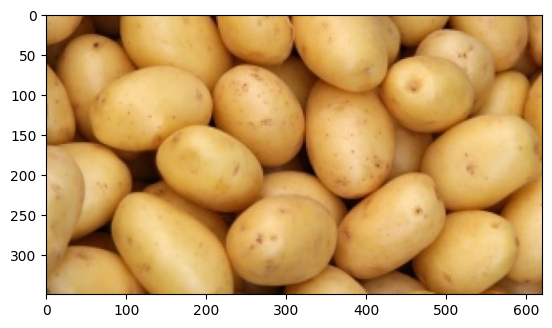

In [21]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("test/potato/Image_4.jpg")
plt.imshow(img[...,::-1])
plt.show()

In [22]:
train_dir = "train"
val_dir = "validation"
test_dir = "test"

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define image size and batch size
img_height, img_width = 128, 128
batch_size = 32


# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,                       #деление каждого пикселя на 255
    rotation_range=10,                      #поворот изображения
    width_shift_range=0.05,                 #сдвиг по горизонтали
    height_shift_range=0.05,                #сдвиг по вертикали 
    zoom_range=0.1,                         #изменение размеров
    shear_range=0.1,                        #диапазон сдвига
    brightness_range=[0.5, 1.5],            #изменение яркости(<1 - затемнение, >1 - увеличение яркости)
    horizontal_flip=True,                   #поворот относительно оси y на 180°
    vertical_flip=True,                     #поворот относительно оси x на 180°
    fill_mode='nearest'                     #правило заполнения точек за пределами границы входных изображений
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


## Создание модели нейронной сети

In [24]:
# Define the model architecture
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])


In [25]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
#Структура нейронной сети
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

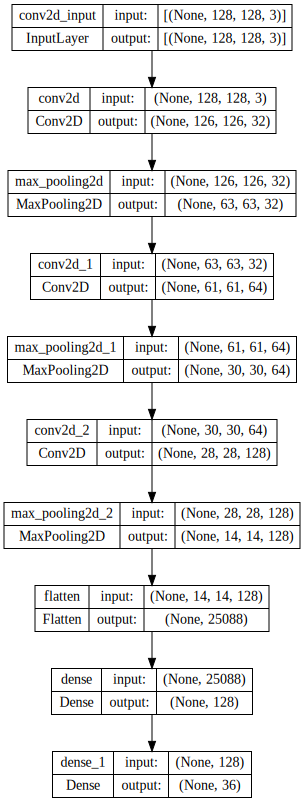

In [27]:
#print(history.history.keys())
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg'))

## Создание callbakcs

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Slowdown of learning speed
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3,             
                                            verbose=1, 
                                            factor=0.5,             
                                            min_lr=0.00001)     

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

filepath="my_net.h5"

#Сохранение нейронной сети если доля правильных ответов на проверочном наборе данных
#лучше чем на предыдущих этапах
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#Замедление скорости обучения, если в течении трех эпох
#если не изменяется доля правильных ответов на проверочном наборе данных
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', #наболюдаемый параметр
                                            patience=3,             #кол-во эпох после которых происходит остановка
                                            verbose=1, 
                                            factor=0.5,             #коэффицент на который будет снижена скорость обучения(lr*factor)
                                            min_lr=0.00001)         #нижняя граница скорости обучения

#колбэк на остановку обучения если точность распознавания тествой выборки не улушается
es = EarlyStopping(
    monitor='val_accuracy',  
    mode='max',              
    patience=8               
)

callbacks_list = [es, checkpoint,learning_rate_reduction]            #список колбэков 

## Обучение модели

In [30]:
!pip install ipython-autotime
%load_ext autotime

# Train the model
epochs = 30
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.4 MB/s eta 0:00:00
Epoch 1/30
 4/98 [>.............................] - ETA: 1:36 - loss: 3.6613 - accuracy: 0.0469

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 [==============================] - ETA: 0s - loss: 3.3290 - accuracy: 0.0815
Epoch 1: val_accuracy improved from -inf to 0.19088, saving model to my_net.h5
98/98 [==============================] - 183s 2s/step - loss: 3.3290 - accuracy: 0.0815 - val_loss: 2.7315 - val_accuracy: 0.1909 - lr: 0.0010
Epoch 2/30
98/98 [==============================] - ETA: 0s - loss: 2.7204 - accuracy: 0.1955
Epoch 2: val_accuracy improved from 0.19088 to 0.26496, saving model to my_net.h5
98/98 [==============================] - 161s 2s/step - loss: 2.7204 - accuracy: 0.1955 - val_loss: 2.3208 - val_accuracy: 0.2650 - lr: 0.0010
Epoch 3/30
98/98 [==============================] - ETA: 0s - loss: 2.4740 - accuracy: 0.2559
Epoch 3: val_accuracy improved from 0.26496 to 0.33618, saving model to my_net.h5
98/98 [==============================] - 179s 2s/step - loss: 2.4740 - accuracy: 0.2559 - val_loss: 2.0384 - val_accuracy: 0.3362 - lr: 0.0010
Epoch 4/30
98/98 [==============================] - ETA: 

## Результаты обучения

In [31]:
import pandas as pd
import numpy as np

pr_Hist=pd.DataFrame.from_dict(history.history)
pr_Hist.tail(10)

,loss,accuracy,val_loss,val_accuracy,lr
20,1.228797,0.628250,0.813143,0.777778,0.0005
21,1.171006,0.636918,0.840096,0.777778,0.0005
22,1.106650,0.652327,0.752410,0.800570,0.0005
23,1.110667,0.650080,0.762627,0.803419,0.0005
24,1.078732,0.661958,0.767592,0.777778,0.0005
25,1.056033,0.666132,0.653356,0.826211,0.0005
26,1.039415,0.672873,0.814436,0.780627,0.0005
27,1.038961,0.678973,0.687669,0.851852,0.0005
28,0.965782,0.690209,0.714872,0.823362,0.0005
29,0.974202,0.689567,0.716241,0.837607,0.0005


time: 43.1 ms (started: 2023-04-01 15:55:25 +00:00)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


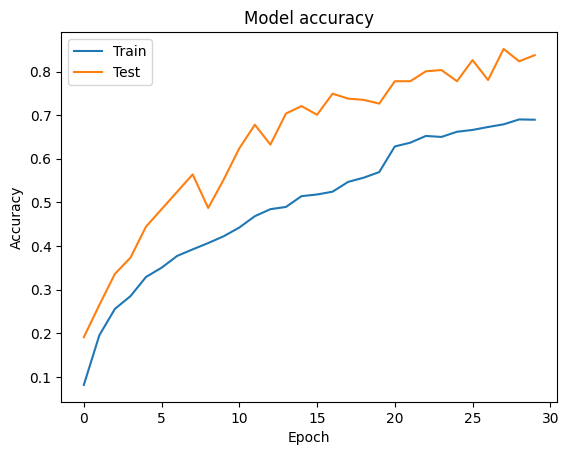

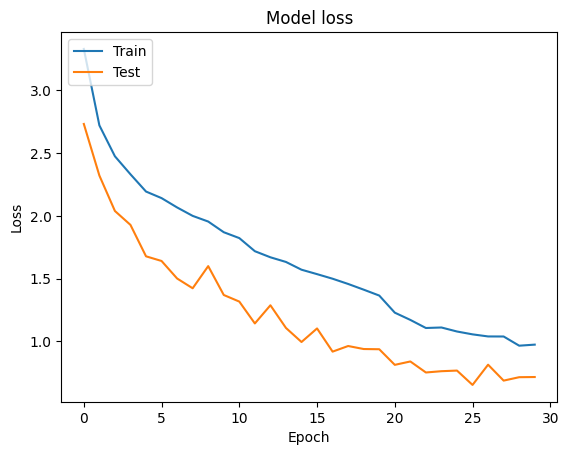

time: 900 ms (started: 2023-04-01 15:55:31 +00:00)


In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt

print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Проверка на реальных данных

In [37]:
from keras.models import load_model
model = load_model('my_net.h5')

time: 3.23 s (started: 2023-04-01 15:59:08 +00:00)


In [42]:
ls

archive.zip  my_dataset.rar  my_net.h5  test/  train/  validation/
time: 185 ms (started: 2023-04-01 15:59:40 +00:00)


In [46]:
#!unzip 'my_dataset.zip'

Archive:  my_dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of my_dataset.zip or
        my_dataset.zip.zip, and cannot find my_dataset.zip.ZIP, period.
time: 201 ms (started: 2023-04-01 16:01:45 +00:00)


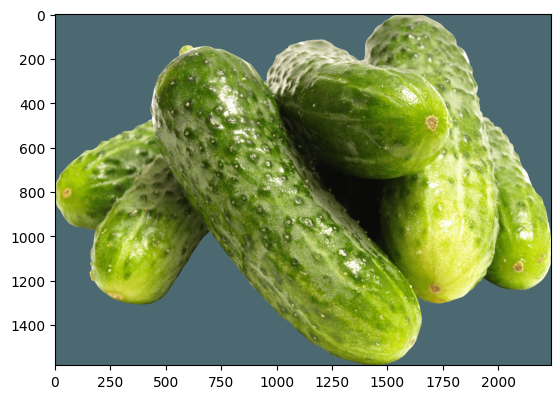

time: 2.46 s (started: 2023-04-01 16:02:55 +00:00)


In [48]:
img = cv2.imread("my_dataset/cucumber.png")
plt.imshow(img[...,::-1])
plt.show()

In [49]:
import os

directory = 'my_dataset'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        print(f)

my_dataset/tomato.png
my_dataset/pear.png
my_dataset/orange.png
my_dataset/kiwi.png
my_dataset/cucumber.png
my_dataset/banana.png
my_dataset/garlic.png
my_dataset/pineapple.png
my_dataset/carrot.png
my_dataset/turnip.png
time: 8.06 ms (started: 2023-04-01 16:03:05 +00:00)


In [50]:
directory = 'train'

classes = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    classes.append(filename)

time: 2.31 ms (started: 2023-04-01 16:03:10 +00:00)


(1, 128, 128, 3)
1/1 [==============================] - 0s 99ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 6.0737684e-35 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]]
(1, 128, 128, 3)
1/1 [==============================] - 0s 53ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 128, 128, 3)
1/1 [==============================] - 0s 26ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 128, 128, 3)
1/1 [=====================

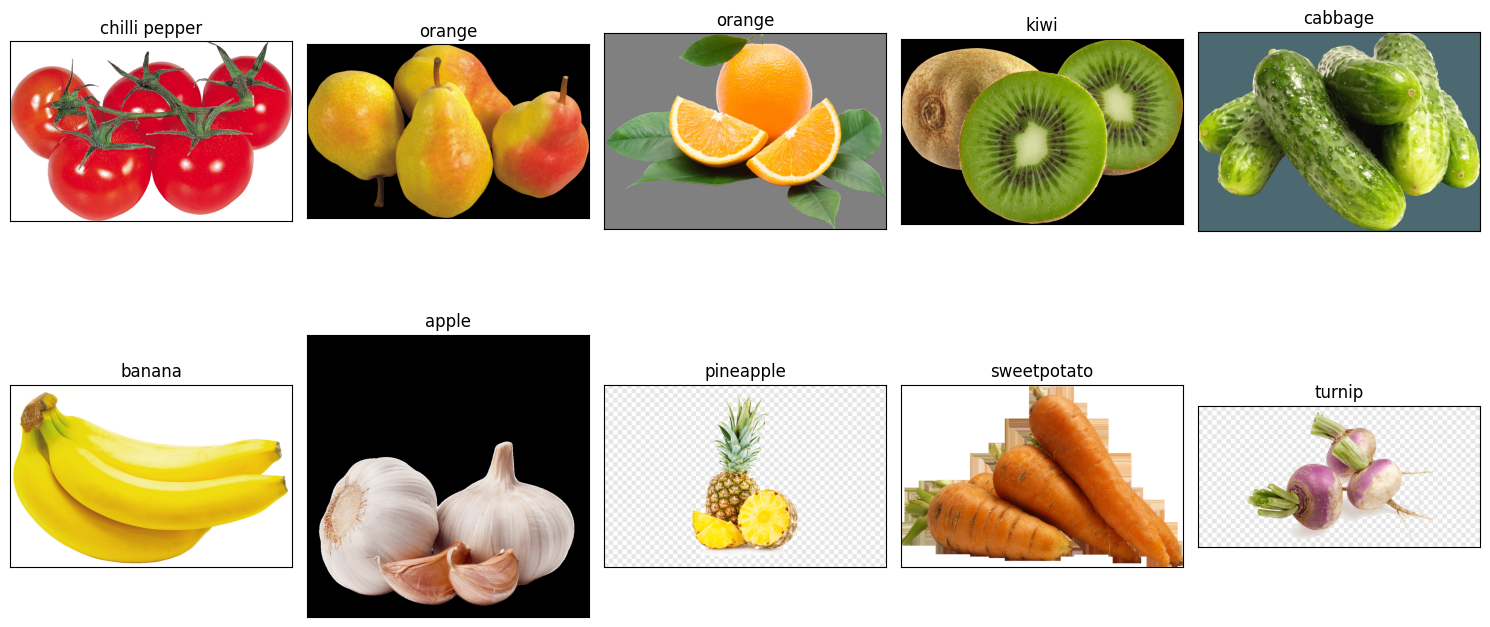

time: 7.36 s (started: 2023-04-01 16:15:51 +00:00)


In [63]:
fig = plt.figure(figsize=(15,8))

directory = 'my_dataset'

counter = 0 
dim = (128, 128)

for filename in os.listdir(directory):
    counter += 1
    f = os.path.join(directory, filename)
    img = cv2.imread(f)[...,::-1]
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    x1 = resized.reshape(-1,128,128,3)
    print(x1.shape)
    pred = model.predict(x1)
    i = np.nonzero(pred)
    print(pred)
    pred = np.vectorize(pred)
    ax = fig.add_subplot(2,5,counter)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    
    ax.set_title(classes[int(i[1][0])])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()